# Training SVM

In [ ]:
import numpy as np
import cv2
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import joblib

data = np.load('/content/character_font.npz')
X = data['images']
y = data['labels']
X = X[:100000]
y = y[:100000]

X_resized = np.zeros((X.shape[0], 28, 28), dtype=np.uint8)
for i in range(X.shape[0]):
    X_resized[i] = cv2.resize(X[i], (28, 28))

hog_features = []
for i in range(X_resized.shape[0]):
    feat = hog(X_resized[i], pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9)
    hog_features.append(feat)

X_hog = np.array(hog_features)
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi SVM: {acc:.4f}")

joblib.dump(clf, 'svm_character_model.pkl')
print("Model SVM berhasil disimpan sebagai 'svm_character_model.pkl'")

Akurasi SVM: 0.7540
Model SVM berhasil disimpan sebagai 'svm_character_model.pkl'


# Training OCR1

Ditemukan 1 karakter
Karakter 1: Posisi (0,0) Size (1327x745) -> P
Predicted Text: P


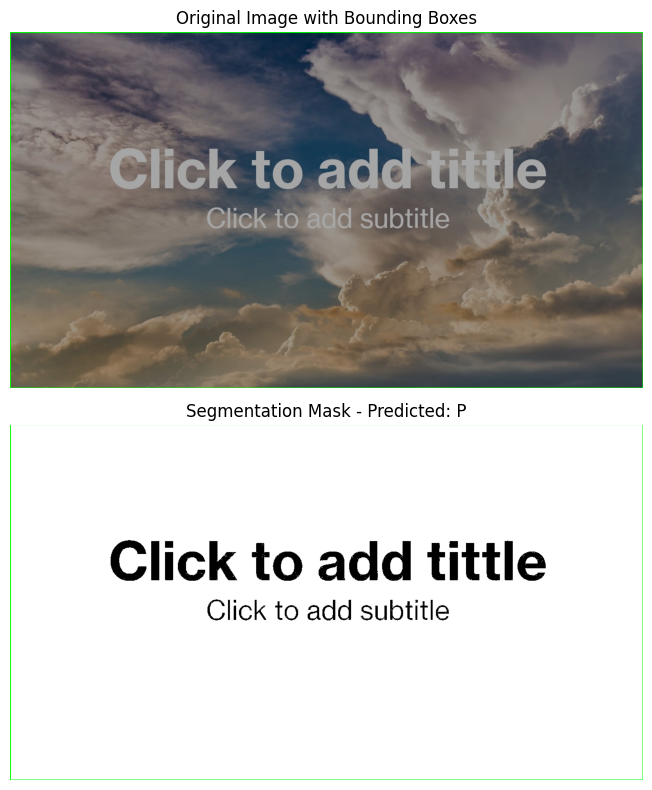

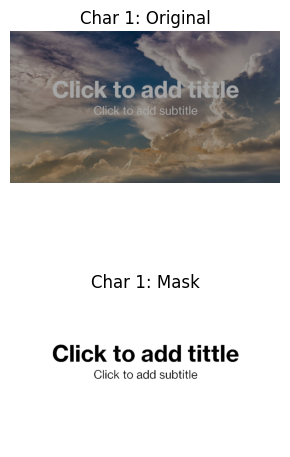

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy.ndimage import gaussian_filter1d
import joblib

model = joblib.load("/content/svm_character_model.pkl")

img = cv2.imread("/content/ocr1.jpg")

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if img is None:
    print("Error: Image not loaded. Please check the image path.")
else:
    _, mask_dark = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY_INV)
    lower_yellow = np.array([20, 50, 50])
    upper_yellow = np.array([40, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_letters = cv2.bitwise_or(mask_dark, mask_yellow)

    kernel_erode = np.ones((2,2), np.uint8)
    mask_eroded = cv2.erode(mask_letters, kernel_erode, iterations=1)
    kernel_dilate = np.ones((1,1), np.uint8)
    mask_processed = cv2.dilate(mask_eroded, kernel_dilate, iterations=1)

    def filter_and_split_contours(mask, min_area=100, max_width_ratio=3.0):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        char_boxes = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = cv2.contourArea(cnt)
            if area < min_area or h < 15 or w < 8:
                continue
            aspect_ratio = w / h
            if aspect_ratio > max_width_ratio:
                num_chars = int(np.round(aspect_ratio / 1.2))
                char_width = w // num_chars
                for i in range(num_chars):
                    new_x = x + i * char_width
                    new_w = w - i * char_width if i == num_chars - 1 else char_width
                    roi = mask[y:y+h, new_x:new_x+new_w]
                    if roi.shape[0] > 0 and roi.shape[1] > 0 and np.sum(roi) > min_area * 10:
                        char_boxes.append((new_x, y, new_w, h))
            else:
                char_boxes.append((x, y, w, h))
        return char_boxes

    def remove_duplicates_and_filter(boxes):
        filtered = []
        boxes_sorted_by_area = sorted(boxes, key=lambda b: b[2]*b[3], reverse=True)

        for i in range(len(boxes_sorted_by_area)):
            x1, y1, w1, h1 = boxes_sorted_by_area[i]
            is_duplicate = False
            for j in range(len(boxes_sorted_by_area)):
                if i != j:
                    x2, y2, w2, h2 = boxes_sorted_by_area[j]
                    x_overlap = max(0, min(x1+w1, x2+w2) - max(x1, x2))
                    y_overlap = max(0, min(y1+h1, y2+h2) - max(y1, y2))
                    intersection = x_overlap * y_overlap
                    area1 = w1 * h1
                    area2 = w2 * h2
                    if area1 > 0 and intersection / area1 > 0.7:
                         if area1 < area2:
                            is_duplicate = True
                            break
            if not is_duplicate:
                filtered.append((x1, y1, w1, h1))
        filtered = sorted(filtered, key=lambda b: b[0])
        return filtered

    char_boxes = filter_and_split_contours(mask_processed)
    char_boxes = remove_duplicates_and_filter(char_boxes)
    char_boxes = sorted(char_boxes, key=lambda b: b[0])
    print(f"Ditemukan {len(char_boxes)} karakter")

    hasil = ""
    for i, (x, y, w, h) in enumerate(char_boxes):
        char_img = mask_letters[y:y+h, x:x+w]
        char_img = 255 - char_img
        resized = cv2.resize(char_img, (28, 28))

        try:
            feat = hog(resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            feat_reshaped = feat.reshape(1, -1)
            label = model.predict(feat_reshaped)[0]
            huruf = chr(int(label) + ord('A'))
            hasil += huruf
            print(f"Karakter {i+1}: Posisi ({x},{y}) Size ({w}x{h}) -> {huruf}")

        except Exception as e:
            print(f"Error extracting HOG or predicting for char {i+1}: {e}")
            hasil += "?"
    print("Predicted Text:", hasil)

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    img_vis = img.copy()
    for i, (x, y, w, h) in enumerate(char_boxes):
        cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_vis, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    axes[0].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image with Bounding Boxes")
    axes[0].axis("off")

    mask_vis = cv2.cvtColor(mask_letters, cv2.COLOR_GRAY2BGR)
    for i, (x, y, w, h) in enumerate(char_boxes):
        cv2.rectangle(mask_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(mask_vis, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    axes[1].imshow(cv2.cvtColor(mask_vis, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Segmentation Mask - Predicted: {hasil}")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

    num_chars_to_show = min(len(char_boxes), 10)
    if num_chars_to_show > 0:
        fig, axes = plt.subplots(2, num_chars_to_show, figsize=(3*num_chars_to_show, 6))
        if num_chars_to_show == 1:
            axes = axes.reshape(-1, 1)

        for i in range(num_chars_to_show):
            x, y, w, h = char_boxes[i]
            roi_orig = img[y:y+h, x:x+w]
            axes[0, i].imshow(cv2.cvtColor(roi_orig, cv2.COLOR_BGR2RGB))
            axes[0, i].set_title(f"Char {i+1}: Original")
            axes[0, i].axis("off")
            roi_mask = mask_letters[y:y+h, x:x+w]
            axes[1, i].imshow(roi_mask, cmap='gray')
            axes[1, i].set_title(f"Char {i+1}: Mask")
            axes[1, i].axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("No characters detected to show individual ROIs.")

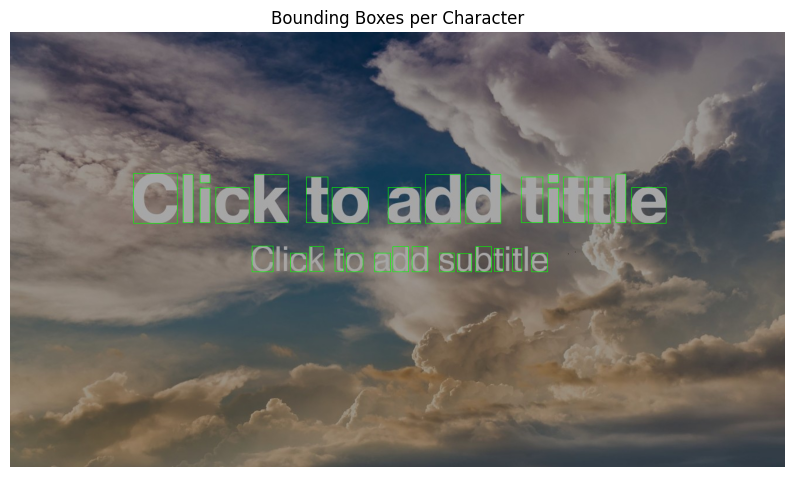

In [ ]:
import cv2
import matplotlib.pyplot as plt

gray_mask = mask_letters

_, thresh = cv2.threshold(gray_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bounding_boxes = []
output_image = img.copy()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 5 and h > 10:
        bounding_boxes.append((x, y, w, h))
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[1] // 10, b[0]))

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Bounding Boxes per Character")
plt.axis("off")
plt.show()

Model CNN berhasil dimuat.

Memulai prediksi untuk 32 karakter...
Error memproses karakter di box (211,243,75,85): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (296,245,17,82): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (325,245,17,14): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (418,245,58,82): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (507,249,37,78): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (711,245,60,83): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (780,245,60,83): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (875,249,37,78): BaseSVC.predict() got an unexpected keyword argument 'verbose'
Error memproses karakter di box (921,2

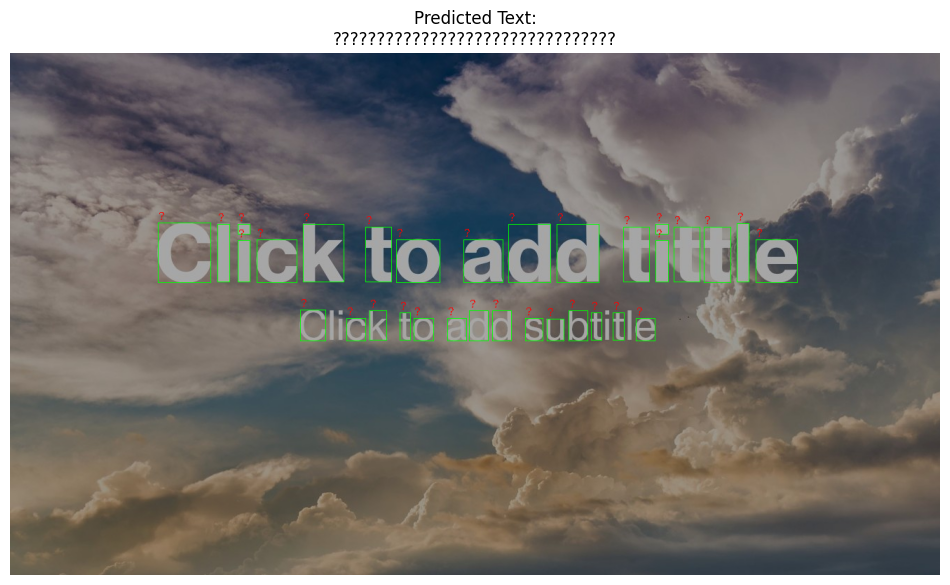

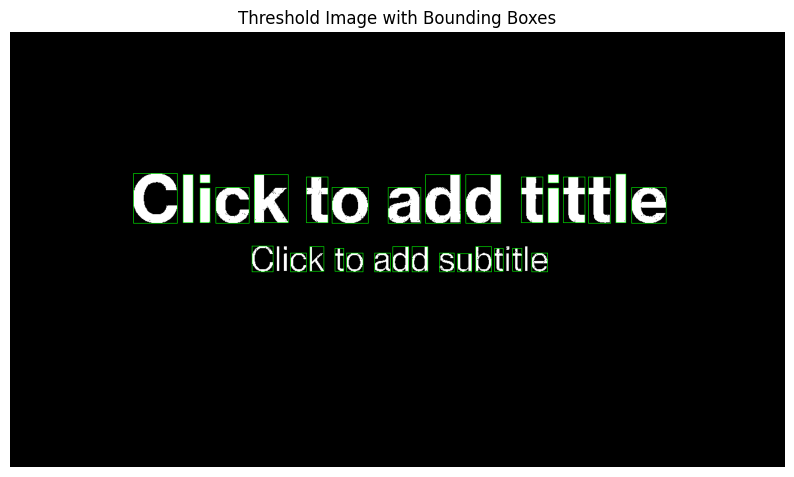

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def show_image(title, img):
    plt.figure(figsize=(10, 6))
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

image_path = gray_mask

gray_mask = mask_letters
_, thresh = cv2.threshold(gray_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bounding_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 5 and h > 10 and h < gray_mask.shape[0] * 0.8 and w < gray_mask.shape[1] * 0.8:
        bounding_boxes.append((x, y, w, h))

bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[1] // 10, b[0]))

try:
    model = joblib.load("/content/svm_character_model.pkl")
    print("Model CNN berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat model CNN: {e}")
    model = None

hasil_prediksi = ""
prev_x = None
prev_y = None

if model is not None:
    char_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
        10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
        20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
    print(f"\nMemulai prediksi untuk {len(bounding_boxes)} karakter...")

    for i, (x, y, w, h) in enumerate(bounding_boxes):
        if prev_y is not None and (y - prev_y) > (h * 0.8):
            if prev_x is not None and (x - (prev_x + prev_w)) > (w * 0.5):
                 hasil_prediksi += " "
            hasil_prediksi += "\n"
        elif prev_x is not None and (x - (prev_x + prev_w)) > (w * 0.7):
             hasil_prediksi += " "

        char_img = thresh[y:y+h, x:x+w]

        try:
            target_size = 28
            if w > h:
                new_w = int(target_size * 0.7)
                new_h = int(h * new_w / w)
            else:
                new_h = int(target_size * 0.7)
                new_w = int(w * new_h / h)

            if new_w <= 0: new_w = 1
            if new_h <= 0: new_h = 1
            resized = cv2.resize(char_img, (new_w, new_h), interpolation=cv2.INTER_AREA)
            top = (target_size - resized.shape[0]) // 2
            bottom = target_size - resized.shape[0] - top
            left = (target_size - resized.shape[1]) // 2
            right = target_size - resized.shape[1] - left
            top = max(0, top)
            bottom = max(0, bottom)
            left = max(0, left)
            right = max(0, right)
            padded = cv2.copyMakeBorder(resized, top, bottom, left, right,cv2.BORDER_CONSTANT, value=0)

            if padded.shape[0] != target_size or padded.shape[1] != target_size:
                 print(f"Warning: Padding failed for char {i}, forcing resize.")
                 padded = cv2.resize(padded, (target_size, target_size), interpolation=cv2.INTER_AREA)
            norm = padded.astype(np.float32) / 255.0
            reshaped = norm.reshape(1, target_size, target_size, 1)

            pred = model.predict(reshaped, verbose=0)
            label_idx = np.argmax(pred)
            confidence = np.max(pred)

            if confidence > 0.5 and label_idx in char_mapping:
                 huruf = char_mapping[label_idx]
            else:
                 huruf = "?"
            hasil_prediksi += huruf

            prev_x = x
            prev_y = y
            prev_w = w
        except Exception as e:
            print(f"Error memproses karakter di box ({x},{y},{w},{h}): {e}")
            hasil_prediksi += "?"

    print("\n--- Hasil Prediksi Teks ---")
    print(hasil_prediksi)

output_image = img.copy()
predicted_chars_list = list(hasil_prediksi.replace('\n', ' ').replace(' ', ''))
char_idx = 0

for i, (x, y, w, h) in enumerate(bounding_boxes):
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
    if char_idx < len(predicted_chars_list):
         predicted_char = predicted_chars_list[char_idx]
         cv2.putText(output_image, predicted_char, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
         char_idx += 1

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Text:\n{hasil_prediksi}")
plt.axis("off")
plt.show()

img_thresh_vis = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
for x, y, w, h in bounding_boxes:
     cv2.rectangle(img_thresh_vis, (x, y), (x + w, y + h), (0, 255, 0), 1)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_thresh_vis, cv2.COLOR_BGR2RGB))
plt.title("Threshold Image with Bounding Boxes")
plt.axis("off")
plt.show()

#Training OCR2

Predicted Text: ZGQSZV


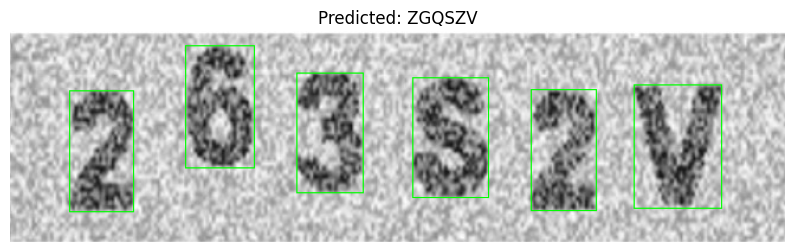

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import joblib
from skimage.feature import hog

img = cv2.imread("ocr2.jpg", cv2.IMREAD_GRAYSCALE)

gaussian = cv2.GaussianBlur(img, (5, 5), 0)
nlm = cv2.fastNlMeansDenoising(gaussian, None, 30, 7, 21)
bilateral_filtered = cv2.bilateralFilter(nlm, d=9, sigmaColor=75, sigmaSpace=75)
_, thresh = cv2.threshold(bilateral_filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

char_boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h > 10 and w > 5:
        char_boxes.append((x, y, w, h))
char_boxes = sorted(char_boxes, key=lambda b: b[0])

clf = joblib.load("svm_character_model.pkl")

hasil = ""
for x, y, w, h in char_boxes:
    char_img = thresh[y:y+h, x:x+w]
    resized = cv2.resize(char_img, (28, 28))
    feat = hog(resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9)
    pred = clf.predict([feat])[0]
    huruf = chr(pred + ord('A'))
    hasil += huruf
print("Predicted Text:", hasil)

img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for x, y, w, h in char_boxes:
    cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 1)

plt.figure(figsize=(10, 4))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {hasil}")
plt.axis("off")
plt.show()

# Training OCR3

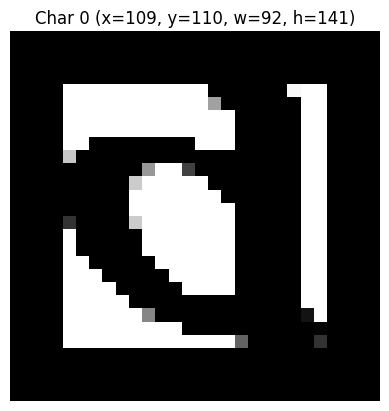

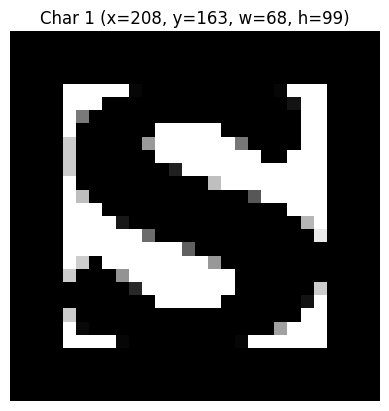

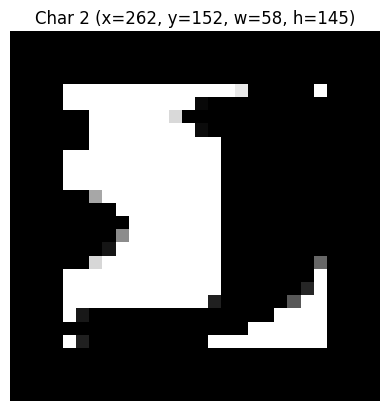

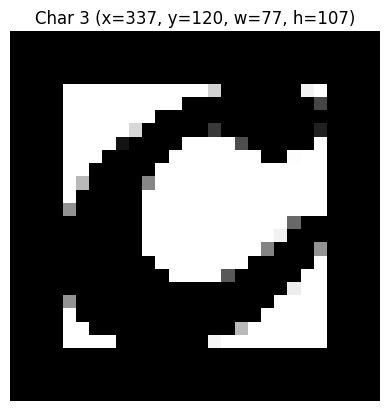

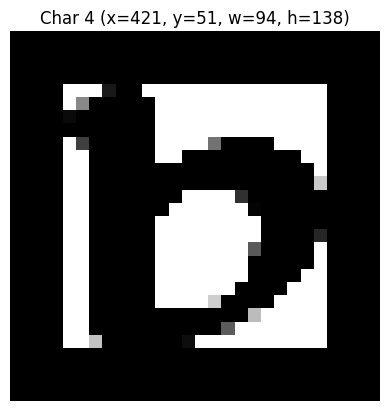

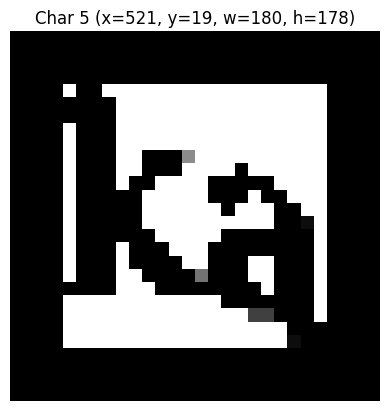

Predicted Text: ZSDZBK


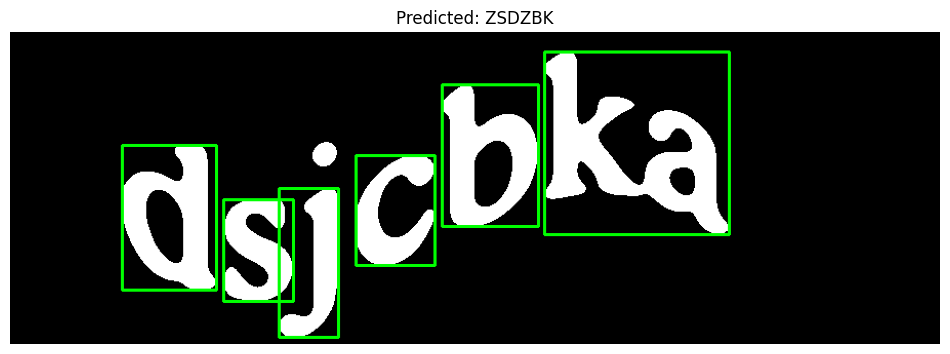

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import joblib

clf = joblib.load("/content/svm_character_model.pkl")

img3 = "/content/ocr3.jpg"
image = cv2.imread(img3)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
denoised = cv2.fastNlMeansDenoising(gray, h=30)
_, otsu_thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
morph = otsu_thresh.copy()
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

char_boxes = []
for cnt in contours:
    if cv2.contourArea(cnt) > 150:
        x, y, w, h = cv2.boundingRect(cnt)
        if 5 < w < 200 and 30 < h < 200:
            char_boxes.append((x, y, w, h))
char_boxes = sorted(char_boxes, key=lambda b: b[0])  # urut kiri ke kanan

hasil = ""
for i, (x, y, w, h) in enumerate(char_boxes):
    char_img = morph[y:y+h, x:x+w]
    char_img = 255 - char_img
    resized_char = cv2.resize(char_img, (20, 20))
    padded = np.pad(resized_char, ((4, 4), (4, 4)), mode='constant', constant_values=0)
    plt.imshow(padded, cmap='gray')
    plt.title(f"Char {i} (x={x}, y={y}, w={w}, h={h})")
    plt.axis("off")
    plt.show()

    feat = hog(padded, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9)
    pred = clf.predict([feat])[0]

    if isinstance(pred, (int, np.integer)):
        huruf = chr(pred + ord('A'))
    else:
        huruf = pred
    hasil += huruf
print("Predicted Text:", hasil)

img_vis = cv2.cvtColor(otsu_thresh, cv2.COLOR_GRAY2BGR)
for x, y, w, h in char_boxes:
    cv2.rectangle(img_vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {hasil}")
plt.axis("off")
plt.show()

# Training OCR4

Ditemukan 4 karakter
Karakter 1: Posisi (45,105) Size (99x92) -> N
Karakter 2: Posisi (175,27) Size (197x174) -> N
Karakter 3: Posisi (428,34) Size (168x134) -> N
Karakter 4: Posisi (697,134) Size (153x101) -> E
Predicted Text: NNNE


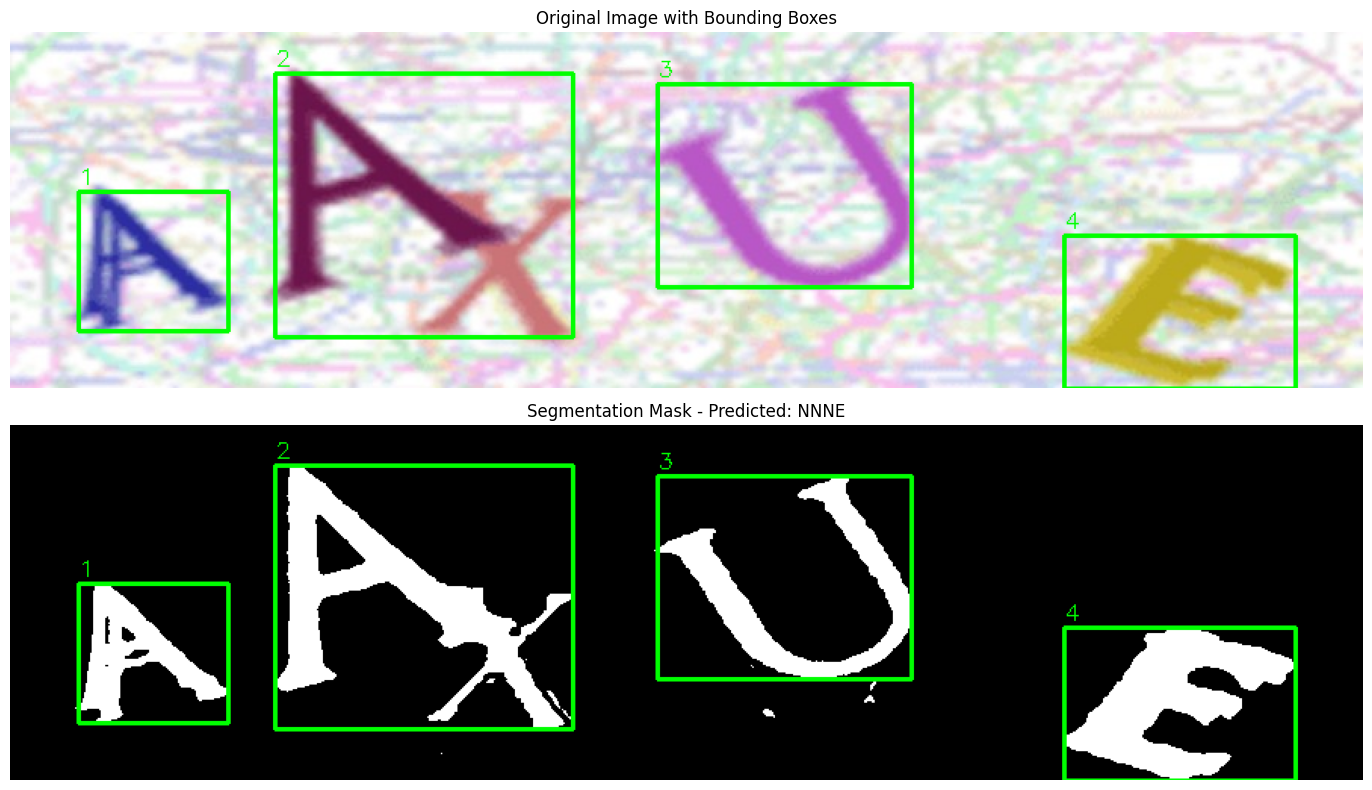

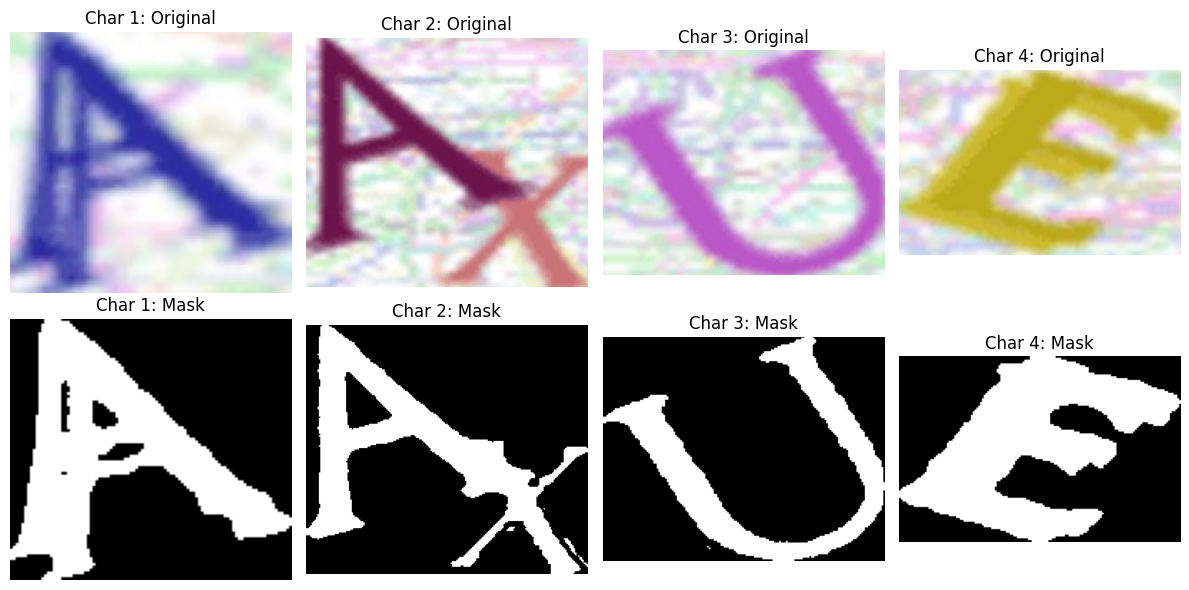

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy import ndimage
import joblib
from scipy.ndimage import gaussian_filter1d

model = joblib.load("/content/svm_character_model.pkl")

img = cv2.imread('/content/ocr4.jpg')

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask_dark = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY_INV)
lower_yellow = np.array([20, 50, 50])
upper_yellow = np.array([40, 255, 255])
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
mask_letters = cv2.bitwise_or(mask_dark, mask_yellow)
kernel_erode = np.ones((2,2), np.uint8)
mask_eroded = cv2.erode(mask_letters, kernel_erode, iterations=1)
kernel_dilate = np.ones((1,1), np.uint8)
mask_processed = cv2.dilate(mask_eroded, kernel_dilate, iterations=1)

def filter_and_split_contours(mask, min_area=100, max_width_ratio=3.0):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    char_boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if area < min_area or h < 15 or w < 8:
            continue

        aspect_ratio = w / h
        if aspect_ratio > max_width_ratio:
            num_chars = int(np.round(aspect_ratio / 1.2))
            char_width = w // num_chars

            for i in range(num_chars):
                new_x = x + i * char_width
                new_w = char_width
                if i == num_chars - 1:
                    new_w = w - i * char_width

                roi = mask[y:y+h, new_x:new_x+new_w]
                if np.sum(roi) > min_area * 10:
                    char_boxes.append((new_x, y, new_w, h))
        else:
            char_boxes.append((x, y, w, h))
    return char_boxes

def split_by_projection(mask, char_boxes):
    refined_boxes = []
    for x, y, w, h in char_boxes:
        roi = mask[y:y+h, x:x+w]
        projection = np.sum(roi, axis=0)
        projection_smooth = gaussian_filter1d(projection.astype(float), sigma=1)

        valleys = []
        threshold = np.mean(projection_smooth) * 0.3

        for i in range(1, len(projection_smooth)-1):
            if (projection_smooth[i] < projection_smooth[i-1] and
                projection_smooth[i] < projection_smooth[i+1] and
                projection_smooth[i] < threshold):
                valleys.append(i)

        if len(valleys) > 0 and w > h * 1.5:
            split_points = [0] + valleys + [w]
            for i in range(len(split_points)-1):
                start_x = split_points[i]
                end_x = split_points[i+1]
                if end_x - start_x > 10:
                    refined_boxes.append((x + start_x, y, end_x - start_x, h))
        else:
            refined_boxes.append((x, y, w, h))
    return refined_boxes

char_boxes = filter_and_split_contours(mask_processed)
char_boxes = split_by_projection(mask_letters, char_boxes)

def remove_duplicates_and_filter(boxes):
    filtered = []
    for i, (x1, y1, w1, h1) in enumerate(boxes):
        if w1 < 8 or h1 < 15:
            continue

        overlap = False
        for j, (x2, y2, w2, h2) in enumerate(boxes):
            if i != j:
                x_overlap = max(0, min(x1+w1, x2+w2) - max(x1, x2))
                y_overlap = max(0, min(y1+h1, y2+h2) - max(y1, y2))
                intersection = x_overlap * y_overlap
                union = w1*h1 + w2*h2 - intersection

                if union > 0 and intersection/union > 0.7:
                    if w1*h1 < w2*h2:
                        overlap = True
                        break

        if not overlap:
            filtered.append((x1, y1, w1, h1))
    return filtered

char_boxes = remove_duplicates_and_filter(char_boxes)
char_boxes = sorted(char_boxes, key=lambda b: b[0])
print(f"Ditemukan {len(char_boxes)} karakter")

hasil = ""
for i, (x, y, w, h) in enumerate(char_boxes):
    char_img = mask_letters[y:y+h, x:x+w]
    char_img = 255 - char_img
    h0, w0 = char_img.shape
    pad = int(max(h0, w0) * 0.1)
    padded = np.pad(char_img, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)
    resized = cv2.resize(padded, (28, 28))

    feat = hog(resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    label = model.predict(feat.reshape(1, -1))[0]
    huruf = chr(label + ord('A'))
    hasil += huruf
    print(f"Karakter {i+1}: Posisi ({x},{y}) Size ({w}x{h}) -> {huruf}")

print("Predicted Text:", hasil)
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

img_vis = img.copy()
for i, (x, y, w, h) in enumerate(char_boxes):
    cv2.rectangle(img_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img_vis, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

axes[0].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
axes[0].set_title(f"Original Image with Bounding Boxes")
axes[0].axis("off")

mask_vis = cv2.cvtColor(mask_letters, cv2.COLOR_GRAY2BGR)
for i, (x, y, w, h) in enumerate(char_boxes):
    cv2.rectangle(mask_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(mask_vis, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
axes[1].imshow(cv2.cvtColor(mask_vis, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Segmentation Mask - Predicted: {hasil}")
axes[1].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, len(char_boxes), figsize=(3*len(char_boxes), 6))
if len(char_boxes) == 1:
    axes = axes.reshape(-1, 1)

for i, (x, y, w, h) in enumerate(char_boxes):
    roi_orig = img[y:y+h, x:x+w]
    axes[0, i].imshow(cv2.cvtColor(roi_orig, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f"Char {i+1}: Original")
    axes[0, i].axis("off")

    roi_mask = mask_letters[y:y+h, x:x+w]
    axes[1, i].imshow(roi_mask, cmap='gray')
    axes[1, i].set_title(f"Char {i+1}: Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

# Training OCR5

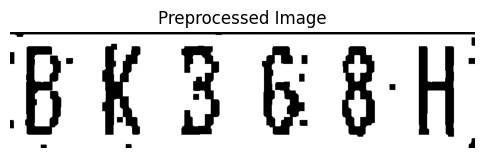

Predicted Text (SVM): DGKNBNBWBB


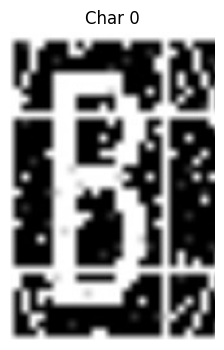

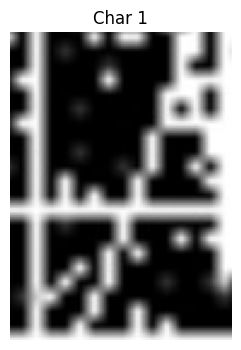

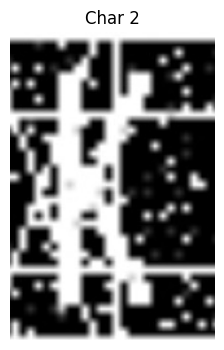

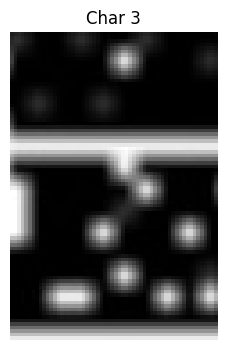

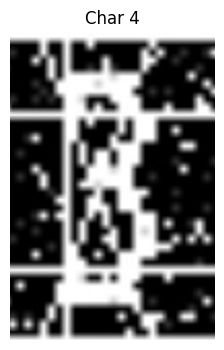

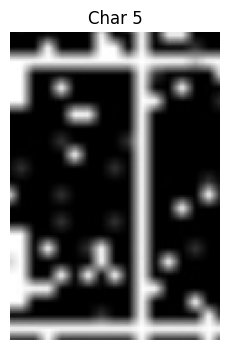

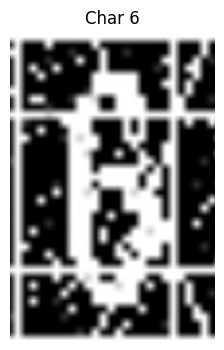

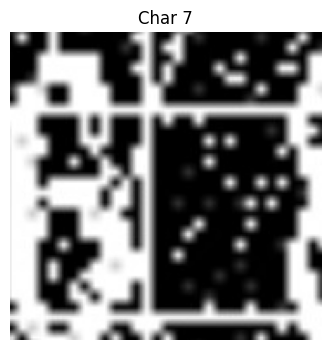

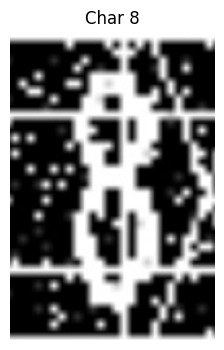

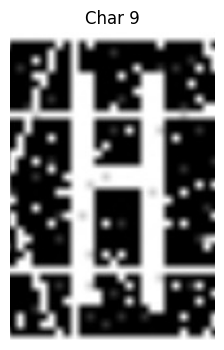

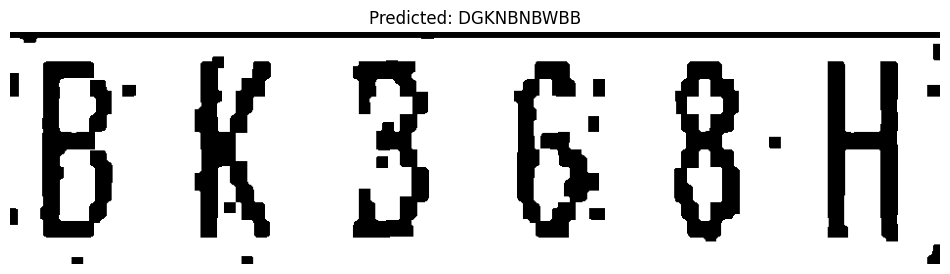

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import joblib

model = joblib.load("/content/svm_character_model.pkl")

def show_image(title, img):
    plt.figure(figsize=(6, 4))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

img_path = '/content/ocr5.jpg'
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray)
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
enhanced = clahe.apply(equalized)
blurred = cv2.medianBlur(enhanced, 3)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dilate = cv2.dilate(thresh, kernel, iterations=6)
eroded = cv2.erode(dilate, kernel, iterations=5)
show_image("Preprocessed Image", eroded)

num_chars = 6
h, w = eroded.shape
char_width = w // num_chars
char_boxes = []

for i in range(num_chars):
    x = i * char_width
    char_boxes.append((x, 0, char_width, h))
height_threshold = eroded.shape[0] * 0.5
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    aspect_ratio = h / float(w)

    if h > height_threshold and 0.5 < aspect_ratio < 5.0 and area > 100:
        char_boxes.append((x, y, w, h))
char_boxes = sorted(char_boxes, key=lambda b: b[0])

hasil = ""
for i, (x, y, w, h) in enumerate(char_boxes):
    char_img = eroded[y:y+h, x:x+w]
    char_img = 255 - char_img

    h0, w0 = char_img.shape
    pad = int(max(h0, w0) * 0.1)
    padded = np.pad(char_img, ((pad, pad), (pad, pad)), mode='constant', constant_values=0)
    resized = cv2.resize(padded, (28, 28))
    feat = hog(resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

    label = model.predict(feat.reshape(1, -1))[0]
    huruf = chr(label + ord('A'))
    hasil += huruf
print("Predicted Text (SVM):", hasil)

img_vis = cv2.cvtColor(eroded, cv2.COLOR_GRAY2BGR)
for i, (x, y, w, h) in enumerate(char_boxes):
    char_crop = image[y:y+h, x:x+w]
    show_image(f"Char {i}", char_crop)

plt.figure(figsize=(12, 4))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {hasil}")
plt.axis("off")
plt.show()